In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.base_cost_models as bcm

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

In [4]:
def get_base_raw_income(power, total_pledge_needed_for_power):
    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=0.20,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        supply_lock_target=0.3
    )

    base_strategy = StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, 3 * YEAR, False)
    base_miner_factory = BaseMinerState.factory(balance=total_pledge_needed_for_power)
    baseline_cfg = SimConfig(
        network=network,
        strategy=base_strategy,
        miner_factory=base_miner_factory,
    )
    base_stats = Simulator(baseline_cfg).run_all(days, stats_interval)
    return base_stats

def get_base_apy_model_income(power, total_pledge_needed_for_power, pledge_borrowed, 
                              borrow_cost_aer_pct=20):
    base_stats = get_base_raw_income(power, total_pledge_needed_for_power)

    # apply cost model(s) on top of this
    borrow_cost_aer = borrow_cost_aer_pct/100.
    income_apy_model = bcm.compute_income_borrow_apy(
        base_stats, 
        pledge_borrowed,
        apy=borrow_cost_aer, 
        sampling_rate_days=1)
    borrow_apy_income = np.array(income_apy_model)
    
    return borrow_apy_income

def get_revenue_take_model_income(power, total_pledge_needed_for_power, pledge_borrowed, 
                                  repayment_cap=1.4, take_rate=0.40):
    base_stats = get_base_raw_income(power, total_pledge_needed_for_power)
    
    income_take_rewards_model, repay_remaining_vector = bcm.compute_income_take_rewards(
        base_stats,
        pledge_borrowed,
        repayment_cap=repayment_cap,
        take_rate=take_rate,
        sampling_rate_days=1
    )
    take_rewards_income = np.array(income_take_rewards_model)
    repay_remaining_vector = np.array(repay_remaining_vector)
    
    return take_rewards_income, repay_remaining_vector

def get_repay_stats(miner_balance, power, max_fee_reward_fraction, shortfall_take_amount, 
                    token_lease_fee=0.2):
    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=token_lease_fee,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=20.0,
        supply_lock_target=0.3
    )
    max_repayment_term = 3. * 365 * DAY
    repay_miner_factory = RepayRatchetShortfallMinerState.factory(
        balance=miner_balance,
        max_repayment_term=max_repayment_term,
        max_fee_reward_fraction=max_fee_reward_fraction,
        reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
    )

    repay_cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, shortfall_take_amount),
        miner_factory=repay_miner_factory,
    )
    stats_repay = Simulator(repay_cfg).run_all(days, stats_interval)
    return pd.DataFrame(data=stats_repay)

In [5]:
get_repay_stats(0, 100, 0.5, 0.2, 0.0)

,day,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,1,0.000095,556.85077,556.85077,556.85077,0.0,0.0,0.000000,0.0,0.0,696.0634,139.21265,19.999994
1,2,0.000095,557.3266,556.61835,557.3266,0.0,0.70825195,1.184255,0.47598985,0.0,696.0634,138.73682,19.931635
2,3,0.000095,557.8023,556.3845,557.8023,0.0,1.4177856,2.368135,0.9503528,0.0,696.0634,138.26111,19.863293
3,4,0.000095,558.27783,556.14923,558.27783,0.0,2.128601,3.551640,1.4230891,0.0,696.0634,137.78558,19.794975
4,5,0.000095,558.75323,555.91266,558.75323,0.0,2.8405762,4.734771,1.8941996,0.0,696.0634,137.31018,19.726677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1092,0.000095,1020.6165,0.0,696.0634,324.5531,1020.6165,1092.726632,72.10929,0.0,696.0634,0.0,0.0
1092,1093,0.000095,1021.45496,0.0,696.0634,325.39154,1021.45496,1093.565088,72.10929,0.0,696.0634,0.0,0.0
1093,1094,0.000095,1022.29315,0.0,696.0634,326.22974,1022.29315,1094.403278,72.10929,0.0,696.0634,0.0,0.0
1094,1095,0.000095,1023.1311,0.0,696.0634,327.0677,1023.1311,1095.241203,72.10929,0.0,696.0634,0.0,0.0


In [6]:
# since we normalize by power, no need to sweep power
delta = 50
# tibs_vec = np.arange(delta, 200+delta, delta)
tibs_vec = [50]

external_borrow_rate_aer_vec = [15, 20, 25, 30, 35]

delta=0.1
shortfall_frac_vec = np.arange(0.2,0.5+delta,delta)
max_fee_reward_fraction_vec = np.arange(0.1,0.2+.02,.02)
fee_take_rate_vec = np.arange(0.2, 0.4+delta, delta)
repayment_cap_vec = np.asarray([1.2,1.4,1.6])
repay_with_shortfall_results = {}
repay_no_shortfall_results = {}
base_apy_model_results = {}
base_takerewards_model_results = {}
pbar = tqdm(total=len(tibs_vec)*len(shortfall_frac_vec))
for tibs in tibs_vec:
    for shortfall_frac in shortfall_frac_vec:
        max_fee_reward_frac_noop = 0.25  # confirmed this is a NOOP
        shortfall_frac_noop = 0.2
        full_balance_needed = get_repay_stats(0, tibs, max_fee_reward_frac_noop, shortfall_frac_noop).iloc[0]['pledge_required']
        shortfall_amt = shortfall_frac * full_balance_needed
        
        # simulate borrowing same amount from external lender w/ the base-cost model and the baseline (Alex's implementation) cost model
        for external_borrow_rate_aer in external_borrow_rate_aer_vec:
            key = '%0.02f,%0.02f,%d' % (tibs, shortfall_frac, external_borrow_rate_aer)
            borrow_apy_income = get_base_apy_model_income(tibs, full_balance_needed, shortfall_amt, external_borrow_rate_aer)
            base_apy_model_results[key] = borrow_apy_income
            
            max_fee_reward_fraction_noop = 0.2
            token_lease_fee = external_borrow_rate_aer/100.
            repay_no_shortfall_df = get_repay_stats(0, tibs, max_fee_reward_fraction_noop,
                                                    0.0, token_lease_fee=token_lease_fee)
            repay_no_shortfall_results[key] = repay_no_shortfall_df

        # simulate borrowing the same amount w/ the revenue-take cost model
        for fee_take_rate in fee_take_rate_vec:
            for repayment_cap in repayment_cap_vec:
                key = '%0.02f,%0.02f,%0.02f,%0.02f' % (tibs, shortfall_frac, fee_take_rate, repayment_cap)
                revenue_take_income, repay_remaining_vector = get_revenue_take_model_income(tibs, full_balance_needed, shortfall_amt, 
                                                                                            repayment_cap=repayment_cap, take_rate=fee_take_rate)
                base_takerewards_model_results[key] = revenue_take_income
#                 print(key, shortfall_amt, revenue_take_income[-1])
            
        for max_fee_reward_fraction in max_fee_reward_fraction_vec:
            key = '%0.02f,%0.02f,%0.02f' % (tibs, max_fee_reward_fraction, shortfall_frac)
            miner_balance = 0
            try:
                repay_df = get_repay_stats(miner_balance, tibs, max_fee_reward_fraction, shortfall_frac, 
                                           token_lease_fee=0.0)
                repay_with_shortfall_results[key] = repay_df
            except RuntimeError as e:
                # this is an illegal combination of parameters
                print('Skipping due to incorrect parametrization: shortfall=%0.02f max_fee_reward_frac=%0.02f' % (shortfall_frac, max_fee_reward_fraction))
                repay_with_shortfall_results[key] = None
        pbar.update(1)

  0%|          | 0/4 [00:00<?, ?it/s]

Skipping due to incorrect parametrization: shortfall=0.40 max_fee_reward_frac=0.20
Skipping due to incorrect parametrization: shortfall=0.50 max_fee_reward_frac=0.10
Skipping due to incorrect parametrization: shortfall=0.50 max_fee_reward_frac=0.12
Skipping due to incorrect parametrization: shortfall=0.50 max_fee_reward_frac=0.14
Skipping due to incorrect parametrization: shortfall=0.50 max_fee_reward_frac=0.16
Skipping due to incorrect parametrization: shortfall=0.50 max_fee_reward_frac=0.18
Skipping due to incorrect parametrization: shortfall=0.50 max_fee_reward_frac=0.20


<IPython.core.display.Javascript object>


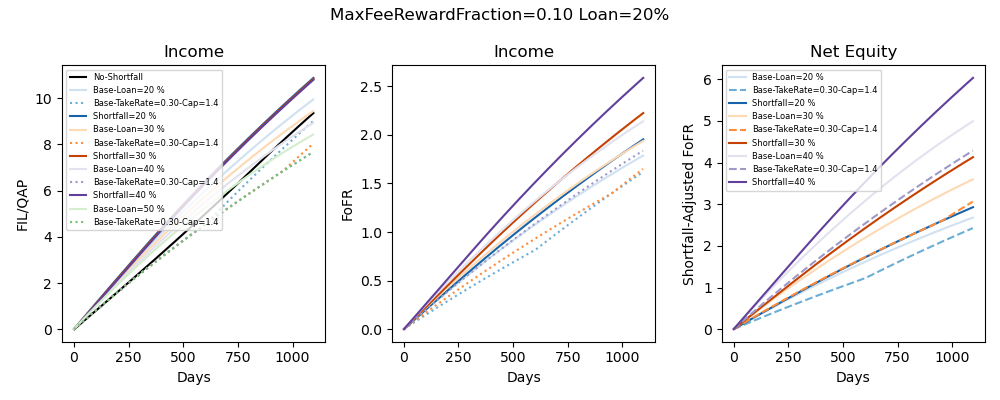

interactive(children=(FloatSlider(value=0.1, description='max_fee_reward_fraction', max=0.2, min=0.1, step=0.0…

<function __main__.update(max_fee_reward_fraction=0.1, external_borrow_rate_aer=20, revenue_take_rate=0.3, repayment_cap=1.4)>

In [7]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Purples'], mpl.colormaps['Greens']]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

tibs=50
def update(max_fee_reward_fraction=0.10, 
           external_borrow_rate_aer=20, 
#            tibs=50,
           revenue_take_rate=0.3, 
           repayment_cap=1.4):
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()
    
    shortfall_taken_pct_noop = 0.2
    repay_no_shortfall_key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct_noop, external_borrow_rate_aer)
    repay_no_shortfall_df = repay_no_shortfall_results[repay_no_shortfall_key]
    repay_no_shortfall_income = repay_no_shortfall_df.iloc[1:]['net_equity']
    norm_factor=tibs
    ax[0].plot(repay_no_shortfall_income/norm_factor, color='k', label='No-Shortfall')
    
    for ii,shortfall_frac in enumerate(shortfall_frac_vec):
        base_key = '%0.02f,%0.02f,%d' % (tibs, shortfall_frac, external_borrow_rate_aer)
        base_apy_model = base_apy_model_results[base_key]
        
        base_revenue_take_key = '%0.02f,%0.02f,%0.02f,%0.02f' % (tibs, shortfall_frac, revenue_take_rate, repayment_cap)
        base_revenue_model = base_takerewards_model_results[base_revenue_take_key]

        repay_key = '%0.02f,%0.02f,%0.02f' % (tibs, max_fee_reward_fraction, shortfall_frac)
        repay_df = repay_with_shortfall_results[repay_key]
        
        base_apy_income = base_apy_model  # rewards - costs
        base_revenue_income = base_revenue_model
        repay_income = repay_df.iloc[1:]['net_equity'] if repay_df is not None else None

        norm_factor = tibs
        ax[0].plot(base_apy_income/norm_factor, color=colors[ii](0.2), label='Base-Loan=%d %%' % (shortfall_frac*100,))
        ax[0].plot(base_revenue_model/norm_factor, color=colors[ii](0.5), linestyle=':', label='Base-TakeRate=%0.02f-Cap=%0.01f' % (revenue_take_rate,repayment_cap))
        if repay_income is not None:
            ax[0].plot(repay_income/norm_factor, color=colors[ii](0.8), label='Shortfall=%d %%' % (shortfall_frac*100,))
        
        if repay_income is not None:
            norm_factor = float(repay_df.iloc[0]['pledge_locked'])
            ax[1].plot(base_apy_income/norm_factor, color=colors[ii](0.2), label='Base-Loan=%d %%' % (shortfall_frac*100,))
            ax[1].plot(base_revenue_model/norm_factor, color=colors[ii](0.5), linestyle=':', label='Base-TakeRate=%0.02f-Cap=%0.01f' % (revenue_take_rate,repayment_cap))
            ax[1].plot(repay_income/norm_factor, color=colors[ii](0.8), label='Shortfall=%d %%' % (shortfall_frac*100,))
        
        # shortfall_adjusted_FoFR = FoFR * (1+s)/(1-s)
        # Note that b/c the normalization factor in the equations below is divided by, we invert the fraction
        # to compute the desired quantity
        if repay_income is not None:
            norm_factor = float(repay_df.iloc[0]['pledge_locked']) * (1.0-shortfall_frac)/(1.0+shortfall_frac)
            ax[2].plot(base_apy_income/norm_factor, color=colors[ii](0.2), label='Base-Loan=%d %%' % (shortfall_frac*100,))
            ax[2].plot(base_revenue_model/norm_factor, color=colors[ii](0.5), linestyle='--', label='Base-TakeRate=%0.02f-Cap=%0.01f' % (revenue_take_rate,repayment_cap))
            ax[2].plot(repay_income/norm_factor, color=colors[ii](0.8), label='Shortfall=%d %%' % (shortfall_frac*100,))
        
    ax[0].legend(fontsize=6)
    ax[0].set_ylabel('FIL/QAP')
    ax[0].set_title('Income')
    ax[0].legend(fontsize=6)
    ax[0].set_xlabel('Days')

    ax[1].set_ylabel('FoFR')
    ax[1].set_xlabel('Days')
    ax[1].set_title('Income')
    
    ax[2].legend(fontsize=6)
    ax[2].set_ylabel('Shortfall-Adjusted FoFR')
    ax[2].set_xlabel('Days')
    ax[2].set_title('Net Equity')

    plt.suptitle('MaxFeeRewardFraction=%0.02f Loan=%d%%' % (max_fee_reward_fraction,external_borrow_rate_aer))
    plt.tight_layout()
    fig.canvas.draw_idle()

update()
interact(update, 
         max_fee_reward_fraction=(0.1,0.2,0.02), 
         external_borrow_rate_aer=(15,35,5),
#          tibs=(50,200,50),
         revenue_take_rate=(0.2, 0.4, 0.1),
         repayment_cap=(1.2,1.6,0.2))